In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import TensorBoard
from keras.layers import *
import numpy

from sklearn.model_selection import train_test_split

dataset = numpy.loadtxt("/grasp_results/merged_file.csv", delimiter=";")
# experiment_number; robustness; H1_F1J2_pos ; H1_F1J2_vel ; H1_F1J2_eff ; H1_F1J1_pos ; 
#   H1_F1J1_vel ; H1_F1J1_eff ; H1_F3J1_pos ; H1_F3J1_vel ; H1_F3J1_eff ; H1_F3J2_pos ;
#   H1_F3J2_vel ; H1_F3J2_eff ; H1_WRJ1_pos ; H1_WRJ1_vel ; H1_WRJ1_eff ; H1_F2J1_pos ; 
#   H1_F2J1_vel ; H1_F2J1_eff ; H1_F2J2_pos ; H1_F2J2_vel ; H1_F2J2_eff ; measurement_number

X = dataset[:, 2:-1]

# only use vel and eff, not pos
new_X = []
for x in X:
    new_X.append([x[1],x[2],x[4],x[5],x[7],x[8],x[10],x[11],x[13],x[14],
                  x[16],x[17],x[19],x[20]])
   
X = numpy.array(new_X)


# expected output is the robustness
Y = dataset[:,1]

best_grasp = max(Y)

print type(Y), Y.shape

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=seed)

print "Max train / test: ", max(y_train), max(y_test)

GOOD_GRASP_THRESHOLD = 100
itemindex = numpy.where(y_test>1.05*GOOD_GRASP_THRESHOLD)
best_grasps = X_test[itemindex[0]]

itemindex = numpy.where(y_test<=0.95*GOOD_GRASP_THRESHOLD)
bad_grasps = X_test[itemindex[0]]

grasp_quality_train = numpy.array([int(i>GOOD_GRASP_THRESHOLD) for i in y_train])
grasp_quality_train = numpy.reshape(grasp_quality_train, (grasp_quality_train.shape[0],))

grasp_quality_test = numpy.array([int(i>GOOD_GRASP_THRESHOLD) for i in y_test])
grasp_quality_test = numpy.reshape(grasp_quality_test, (grasp_quality_test.shape[0],))

print "Test qualities: ", grasp_quality_test[10:20], " good grasp ratio: ", (float(100*sum(grasp_quality_test))/grasp_quality_test.shape[0])
print "Train qualities: ", grasp_quality_train[10:20], " good grasp ratio: ", (float(100*sum(grasp_quality_train))/grasp_quality_train.shape[0])


<type 'numpy.ndarray'> (296447,)
Max train / test:  311.423949071 311.423949071
Test qualities:  [0 0 1 1 1 1 1 1 0 1]  good grasp ratio:  47.2946533985
Train qualities:  [0 1 1 1 0 1 0 0 0 1]  good grasp ratio:  47.1194187817


In [12]:
# create model
model = Sequential()

model.add(Dense(50, input_dim=len(X[0]), activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
tensorboard = TensorBoard(log_dir='/Graph', histogram_freq=0, write_graph=False, embeddings_freq=1, write_images=False)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
# Fit the model
model.fit(X_train, grasp_quality_train, validation_split=0.20, epochs=200,
          batch_size=50000, callbacks=[tensorboard])




Train on 83122 samples, validate on 20781 samples
Epoch 1/200
83122/83122 [==============================] - 0s - loss: 1.2650 - acc: 0.7746 - val_loss: 0.9754 - val_acc: 0.7622
Epoch 2/200
83122/83122 [==============================] - 0s - loss: 0.8969 - acc: 0.7678 - val_loss: 0.6937 - val_acc: 0.8495
Epoch 3/200
83122/83122 [==============================] - 0s - loss: 0.6561 - acc: 0.8744 - val_loss: 0.5695 - val_acc: 0.9294
Epoch 4/200
83122/83122 [==============================] - 0s - loss: 0.5581 - acc: 0.9339 - val_loss: 0.5111 - val_acc: 0.9336
Epoch 5/200
83122/83122 [==============================] - 0s - loss: 0.5087 - acc: 0.9306 - val_loss: 0.4734 - val_acc: 0.9389
Epoch 6/200
83122/83122 [==============================

In [15]:
scores = model.evaluate(X_test, grasp_quality_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

25632/25976 [============================>.] - ETA: 0s
acc: 97.85%


In [16]:
import h5py
model.save("/grasp_results/saved_model.h5")

In [17]:
predictions = model.predict(best_grasps)
predictions_bad_grasp = model.predict(bad_grasps)

rounded = [round(x[0]) for x in predictions]

number_of_false_negative = len([i for i, x in enumerate(rounded) if x == 0.0])
number_of_true_positive = len([i for i, x in enumerate(rounded) if x == 1.0])
print "False negatives: ",number_of_false_negative
print "True Positives: ",number_of_true_positive
print (len(rounded))

False negatives:  281
True Positives:  6091
6372


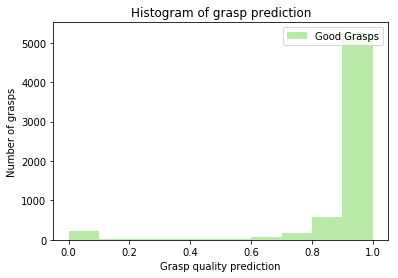

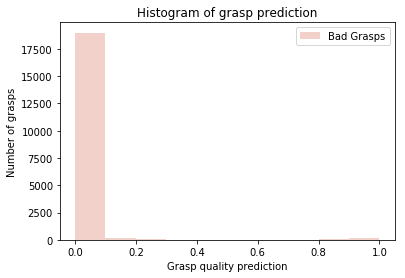

In [18]:
%matplotlib inline

import matplotlib.pyplot as plt


plt.hist(predictions,
         color='#77D651',
         alpha=0.5,
         label='Good Grasps')

plt.title('Histogram of grasp prediction')
plt.ylabel('Number of grasps')
plt.xlabel('Grasp quality prediction')
plt.legend(loc='upper right')

plt.show()

# Plot a histogram of defender size
plt.hist(predictions_bad_grasp,
         color='#D66751',
         alpha=0.3,
         label='Bad Grasps')

plt.title('Histogram of grasp prediction')
plt.ylabel('Number of grasps')
plt.xlabel('Grasp quality prediction')
plt.legend(loc='upper right')

plt.show()